# Compression of Recurrent Neural Networks (RNNs)

This notebook provides a demo for compressing RNNs using all three post-hoc methods, i.e. BMR / SNR / SPR.

## GPU support

This block is to disable GPU execution of TensorFlow. Depending on your system, enabling GPU may result in faster training.

*Comment this block to enable GPU execution*

In [1]:
# Disable GPU execution
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Packages

We import some standard packages as wel as TensorFlow and our own Bayesian TensorFlow package, make sure you have them installed prior!

In [2]:
# Import packages
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import bayesian_tensorflow as btf

## Setup

Below we set the experiment details for the demo, mostly concerning the specific dataset and which inference method.

The `reparam` variable is only used when the `method` is set to BBB (Bayes-by-Backprop).

In [3]:
# Set hyperparameters
name     = 'sine'
method   = 'BBB'          # 'BBB' or 'VBP'
reparam  = 'global'       # 'local' or 'global'
seed     =  60

In [4]:
# 'Fixed' hyperparams.
batch_size =  16
seq_len    =  8

## Dataset

We load the specific dataset using the function `toy.load` and specifying the name of the dataset.

In [5]:
# Get custom datasets module
from datasets import toy

# Load dataset
(x, y) = toy.load(name=name)

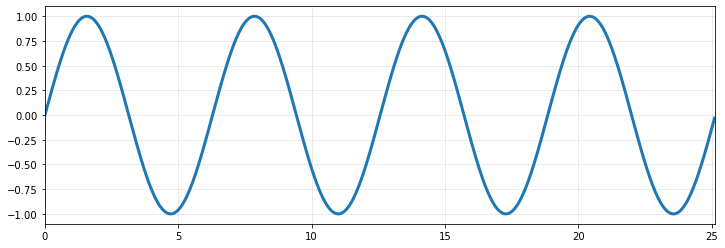

In [6]:
# Plot training data
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(x, y, lw=3)
ax.set_xlim([x[0], x[-1]])
ax.grid(linewidth=0.5, alpha=0.5);

In [7]:
# Total data size
n_data = tf.cast(tf.shape(x)[0], dtype=tf.float32)

In [8]:
# Set random seed
tf.random.set_seed(seed)

# Create TF-dataset
dataset = tf.keras.utils.timeseries_dataset_from_array(
    y, y[seq_len:],
    sequence_length=seq_len,
    batch_size=batch_size
)

## Model

We re-create the model used during training and load the saved model parameters.

__*You need to have trained a model first before you can run this notebook, no save models are included!*__

In [9]:
# Get save directory
save_dir = './models/' + method + '/' + name
if (method == 'BBB'): save_dir += '/' + reparam

# Model structure
if method == 'BBB':
    model = tf.keras.models.Sequential([
        tf.keras.layers.RNN(btf.layers.GRUCellBBB(16, reparam=reparam), 
                            input_shape=(seq_len, 1), unroll=True),
        btf.layers.DenseBBB(1, reparam=reparam),
        btf.layers.GammaBBB(1),
    ])
elif method == 'VBP':
    model = tf.keras.models.Sequential([
        tf.keras.layers.RNN(btf.layers.GRUCellVBP(16, is_input=True), 
                            input_shape=(seq_len, 1), unroll=True),
        btf.layers.DenseVBP(1, is_output=True),
        btf.layers.GammaVBP(1),
    ])

# Load weights
model.load_weights(save_dir + '/weights');

In [10]:
model.summary(line_length=75, positions=[0.55, 0.85, 1.0, 1.0])

Model: "sequential"
___________________________________________________________________________
 Layer (type)                            Output Shape          Param #     
 rnn (RNN)                               (None, 16)            2592        
                                                                           
 dense_bbb (DenseBBB)                    (None, 1)             34          
                                                                           
 gamma_bbb (GammaBBB)                    (None, 1, 3)          2           
                                                                           
Total params: 2,628
Trainable params: 1,764
Non-trainable params: 864
___________________________________________________________________________


## Functions

We set the proper VFE evaluation function, based on the specified inference method.

We aslo set the number of samples, as BBB uses 10 samples for evaluation.

In [11]:
# Select proper VFE functions
if method == 'BBB':
    eval_func = btf.evaluation.BBB
    n_runs = 10
elif method == 'VBP':
    eval_func = btf.evaluation.VBP
    n_runs = 1

In [12]:
# Custom evaluation function
def eval_vfe():
    
    # Set random seed
    tf.random.set_seed(seed)
    # Variable to store result
    vfe = 0.
        
    # Loop over runs
    for run in range(n_runs):
        
        # Loop over test data
        for x_batch, y_batch in dataset:
            
            # Get batch VFE
            vfe += eval_func(model, x_batch, y_batch, n_data)

    # Return total Free Energy
    return vfe / n_runs

## Pre-computations

We pre-compute all the post-hoc compression values, to not have to calculate them again every pruning step.

The values are stored in a vector for easier computations, but we save the indices needed to map them to the correct model parameter.

In [13]:
# Save model weights
theta = model.get_weights()

# Set weight indices
if method == 'BBB':
    th_i = np.array([0, 2, 4, 9, 11])
elif method == 'VBP':
    th_i = np.array([0, 2, 4, 6, 8])
    
# Create indices for reshaping
idx = np.zeros(6, dtype=int)
for i in range(1, len(th_i)+1):
    if theta[th_i[i-1]].ndim == 1: idx[i] = idx[i-1] + theta[th_i[i-1]].shape[0]
    else: idx[i] = idx[i-1] + theta[th_i[i-1]].shape[0] * theta[th_i[i-1]].shape[1]

In [14]:
# Initialize arrays
mu, rho = np.array([]), np.array([])
# Loop over weight indices
for i in th_i:
    mu  = np.append(mu, theta[i].flatten())
    rho = np.append(rho, theta[i+1].flatten())
        
# Compute sigma
sigma = tf.math.softplus(rho).numpy()
if (method == 'VBP'): sigma = np.sqrt(sigma)

In [15]:
# Intermediate variables
pi_i = 1. / 1e-16
p_f  = 1. / sigma**2
p_i  = p_f + pi_i - 1. / 1.
mu_i = p_f * mu / p_i

# Compute theoretical BMR values
bmr_vals = 0.5 * ((mu**2 * p_f - mu_i**2 * p_i) - np.log(pi_i * p_f / p_i * 1.))

# Sort values
bmr_idx  = np.argsort(bmr_vals)
bmr_sort = bmr_vals[bmr_idx]

In [16]:
# Compute SNR values
snr_vals = np.log(np.abs(mu) / sigma)

# Sort values
snr_idx  = np.argsort(snr_vals)
snr_sort = snr_vals[snr_idx]

In [17]:
# Compute SPR values
spr_vals = np.log(np.abs(mu) + sigma)

# Sort values
spr_idx  = np.argsort(spr_vals)
spr_sort = spr_vals[spr_idx]

## Compression

We now perform compression in steps of 1%, for all three post-hoc methods.

After compressing, we compute the VFE of the model and save the results to be plotted.

In [18]:
# Empty arrays for VFE
bmr  = np.zeros(100)
snr  = np.zeros(100)
spr  = np.zeros(100)
frac = np.zeros(100)

In [19]:
# Get default VFE value
bmr[0] = eval_vfe()
snr[0], spr[0] = bmr[0], bmr[0]

In [20]:
# Compress per 1% for BMR
for n in tqdm(range(1,100), desc='BMR Compression'):
    
    # Set pruning number
    k = int(len(bmr_vals) * n/100)
    frac[n] = k / len(bmr_vals)
    
    # Prune parameters
    m_new, r_new = np.copy(mu), np.copy(rho)
    m_new[bmr_idx[:k]] = 0
    r_new[bmr_idx[:k]] = -1e5
    
    # Copy model parameters
    w = theta.copy()
    
    # Updates weights using idx
    for j, i in enumerate(th_i):
        # Reshape parameters
        w[i]   = m_new[idx[j]:idx[j+1]].reshape(w[i].shape)
        w[i+1] = r_new[idx[j]:idx[j+1]].reshape(w[i+1].shape)

    # Set new parameters
    model.set_weights(w)
    
    # Evaluate VFE of pruned model
    bmr[n] = eval_vfe()

BMR Compression:   0%|          | 0/99 [00:00<?, ?it/s]

In [21]:
# Compress per 1% for SNR
for n in tqdm(range(1,100), desc='SNR Compression'):
    
    # Set pruning number
    k = int(frac[n] * len(snr_vals))
    
    # Prune parameters
    m_new, r_new = np.copy(mu), np.copy(rho)
    m_new[snr_idx[:k]] = 0
    r_new[snr_idx[:k]] = -1e5
    
    # Copy model parameters
    w = theta.copy()
    
    # Updates weights using idx
    for j, i in enumerate(th_i):
        # Reshape parameters
        w[i]   = m_new[idx[j]:idx[j+1]].reshape(w[i].shape)
        w[i+1] = r_new[idx[j]:idx[j+1]].reshape(w[i+1].shape)

    # Set new parameters
    model.set_weights(w)
    
    # Evaluate VFE of pruned model
    snr[n] = eval_vfe()

SNR Compression:   0%|          | 0/99 [00:00<?, ?it/s]

In [22]:
# Compress per 1% for SPR
for n in tqdm(range(1,100), desc='SPR Compression'):
    
    # Set pruning number
    k = int(frac[n] * len(snr_vals))
    
    # Prune parameters
    m_new, r_new = np.copy(mu), np.copy(rho)
    m_new[spr_idx[:k]] = 0
    r_new[spr_idx[:k]] = -1e5
    
    # Copy model parameters
    w = theta.copy()
    
    # Updates weights using idx
    for j, i in enumerate(th_i):
        # Reshape parameters
        w[i]   = m_new[idx[j]:idx[j+1]].reshape(w[i].shape)
        w[i+1] = r_new[idx[j]:idx[j+1]].reshape(w[i+1].shape)

    # Set new parameters
    model.set_weights(w)
    
    # Evaluate VFE of pruned model
    spr[n] = eval_vfe()

SPR Compression:   0%|          | 0/99 [00:00<?, ?it/s]

In [23]:
# Compute theoritical VFE change from BMR
vfe = np.zeros(100)
vfe[0] = bmr[0]
for i in range(1,100):
    k = int(frac[i] * len(bmr_vals))
    vfe[i] = vfe[0] + np.sum(bmr_sort[:k])

## Dataframe

We save the results in a single CSV file, which also contains the theoretical change in VFE from BMR.

In [24]:
# Set data
d = {'fraction': frac,
     'theoretical bmr': vfe,
     'observed bmr': bmr,
     'observed snr': snr,
     'observed spr': spr}

# Create dataframe
df = pd.DataFrame(data=d)

# Save to csv
df.to_csv(save_dir + '/comp.csv', index=False)

## Plots

Finally, we plot the resulting change in VFE for different pruning rate for all methods.

You can specify the y-range of the plot below.

In [25]:
# Set y-axis range
ylim = [-1200, -900]

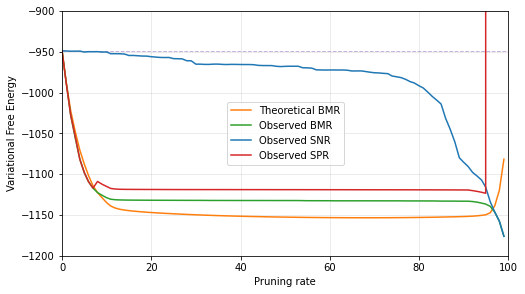

In [26]:
# Create figure
fig = plt.figure(figsize=[8,4.5])

# Baseline plot
plt.plot(100*np.array([0,1]), vfe[0]*np.ones(2), color='C4', 
         linestyle='--', alpha=0.5, linewidth=1)
# Theoretical BMR
plt.plot(frac*100, vfe, color='C1', label='Theoretical BMR')
# Obeserved BMR
plt.plot(frac*100, bmr, color='C2', label='Observed BMR')
# Observed SNR
plt.plot(frac*100, snr, color='C0', label='Observed SNR')
# Observed SPR
plt.plot(frac*100, spr, color='C3', label='Observed SPR')

# Other figure stuff
plt.xlabel('Pruning rate')
plt.ylabel('Variational Free Energy')
plt.xlim([0, 100])
plt.ylim(ylim)
plt.grid(linewidth=0.5, alpha=0.5)
plt.legend()
plt.show()